In [3]:
from math import *
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

## Partie Algorithmie

### Création du vecteur de départ

page numéroté num 156

In [264]:
def alp(p):
    i = np.arange(p+1)
    return (1/2) * (1 - np.cos( (2*i+1)*np.pi / (2*p+1)))

In [265]:
def bet(p):
    i = np.arange(p+1)
    return (1/2) * (1 - np.cos( 2*i*np.pi / (2*p+1)))

page numéroté num 157

In [266]:
def start_point(p):
    I = np.zeros((2*(p+1),1))
    I[:p+1,0] = alp(p)
    I[p+1:,0] = bet(p)
    return I

### Création de la Jacobienne

page numéroté num 157 puis 163

In [267]:
def a_prime_beta(p) : 
    #i verif
    i = np.arange(0,p) + 1
    #eta verif
    eta = ((2*(p-i)+1)*np.pi) / (2*p+1)
    
    #left et right verif
    left = (2*p*np.cos(p*eta)) / (np.cos(eta) + 1)
    right = (np.sin(p*eta) / np.sin(eta)) * ( 2*p + 2/(np.cos(eta) + 1))
    return left + right

In [268]:
def b_prime_alpha(p) :
    #i et teta vérif
    i = np.arange(0,p)
    teta = ( 2*(p-i)*np.pi) / (2*p+1)
    
    #left et right vérif
    left = (2*p*np.cos(p*teta)) / (np.cos(teta) - 1)
    right = (np.sin(p*teta) / np.sin(teta)) * ( 2*p - 2/(np.cos(teta) - 1))
    return left + right

In [269]:
def Jacobian_X0(p,h, x,function,eps) : 
    f = function(x,h)
    f_max = np.max(f)
    f_eps = max(f_max, eps)
    I = np.zeros(2*p)

    I[:p] = a_prime_beta(p)
    I[p:] = b_prime_alpha(p)
  
    return np.sqrt(f_eps)*np.diag(I)

### Création de l'interpolation a et b 

page numéroté num 155

In [270]:
def a(x,alpha,h, p,function, eps):
    som = 0
    for i in range(p+1):
        mul = 1 
        for j in range(p+1) :
            if i != j :
                mul = mul * ((x - alpha[j]) / (alpha[i] - alpha[j])) 
        inter = (-1)**(i+p)* np.sqrt(max(function(alpha[i],h),eps) / alpha[i]) * mul
        som += inter
    return som

In [398]:
def b(x,beta,h,p, function,eps):
    som = 0
    for i in range(p+1) : 
        mul = 1 
        for j in range(p+1) : 
            if i != j :
                mul = mul * ((x - beta[j]) / (beta[i] - beta[j]))
        som += (-1)**(i+p) * sqrt(max(function(beta[i],h), eps) / ( 1 - beta[i])) * mul
    return som

### Vecteur têta

page numéroté num 155

In [372]:
def teta_teta(x, h, p, function,eps) : 
    teta = np.zeros((2*p,1))
    alpha = x[:p]
    alpha_new = np.concatenate(( alpha, [[1]]))
    beta = x[p:]
    beta_new = np.concatenate(([[0]],beta))
    
    teta[p:] = a(beta, alpha_new, h, p, function, eps) 
    teta[:p] = b(alpha, beta_new, h, p, function,eps)
    return teta 

### Splitting node 

### Algorithme Newton-Raphson

page numéroté num 155

In [373]:
def G_hat(x,h, p, function,eps) : 
    J = Jacobian_X0(p,h,x, function, eps)
    tet = teta_teta(x, h, p, function,eps)
    d = npl.solve(J,tet)
    return x - d

In [374]:
def Newton_Raphson(p,h ,function,eps=1e-3)  :
    X0 = start_point(p)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat(X,h,p,function,eps)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR

### Création des points d'interpolation = Lukacs

In [375]:
def polynom(x, a, b):
    sol = x*(a**2) +(1-x)*(b**2)
    return sol

### Affichage du polynome

In [376]:
def polynom_display(xn,poln, x, pol,h, real_func):
    x0 = np.linspace(0,1,100)
    
    plt.figure()
    plt.plot(x, pol, '-b')
    plt.plot(xn,poln, 'ob', label ="Points d'interpolation")
    plt.plot(x0, real_func(x0,h), '-r', label = "Fonction à interpoler")
    plt.legend()
    plt.show()   

In [377]:
def polynom_display2(xn,pol,h, real_func):
    x0 = np.linspace(0,1,100)
    
    plt.plot(xn,pol, 'ob', label ="Points d'interpolation")
    plt.plot(x0, real_func(x0,h), '-r', label = "Fonction à interpoler")
    plt.title("Interpolation de la fonction")

### Interpolation par un polynome

In [378]:
def interpol(p,h,function, eps=1e-3) :
    X, ERR = Newton_Raphson(p, h, function, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x

In [379]:
def erreur(xn, poln, function, h) : 
    f = function(xn, h)
    dif = np.abs(f - poln)
    n = np.shape(dif)[0]
    dif = np.reshape(dif, (n))
    xn = np.reshape(xn, (n))
    som = 0
    for i in range(n-1) : 
        som += (xn[i+1]-xn[i]) * (dif[i+1]+dif[i]) / 2
    return som 

In [380]:
def find_order(x, err) :
    return (log10(err[-1])-log10(err[0])) /  (log10(x[-1])-log10(x[0]))

## Création des fonctions

#### Fonctions polynomes

In [381]:
def pol1(x,h):
    x = x*h
    return x**2+1

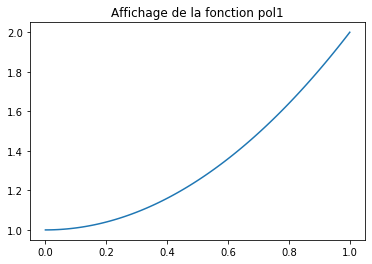

In [382]:
x = np.linspace(0,1,100)
h = 1 
plt.title("Affichage de la fonction pol1")
plt.plot(x , pol1(x,h))

In [143]:
def pol2(x,h) :
    x= x*h
    return (10**5)*(x**10)*(1-x)**7 + 0.01

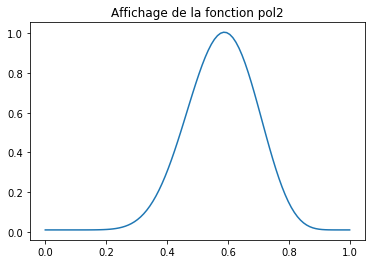

In [144]:
x = np.linspace(0,1,100)
h = 1 
plt.title("Affichage de la fonction pol2")
plt.plot(x , pol2(x,h))

In [145]:
def pol3(x,h) :
    x = x*h
    return 10*(x-1/2)**4 +3

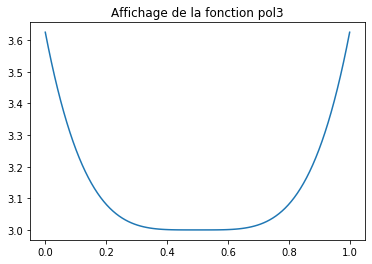

In [146]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction pol3")
plt.plot(x , pol3(x,h))

In [147]:
def pol4(x,h) : 
    x = x*h
    return 10**5 * (x**10)* (1-x)**7 + 0.01

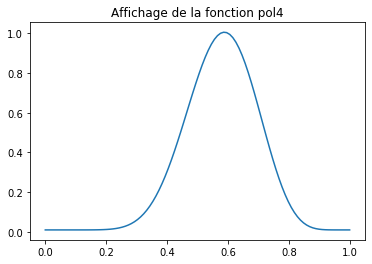

In [148]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction pol4")
plt.plot(x , pol4(x,h))

#### Focntions hyperboliques

In [151]:
def hyp1(x,h) :
    x=x*h
    return 1/(1-x)

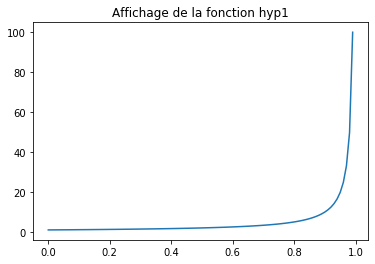

In [154]:
x = np.linspace(0,0.99,99)
h = 1
plt.title("Affichage de la fonction hyp1")
plt.plot(x , hyp1(x,h))

In [156]:
def hyp2(x,h) :
    x = x*h
    return 1/(1+25*(2*x-1)**2)

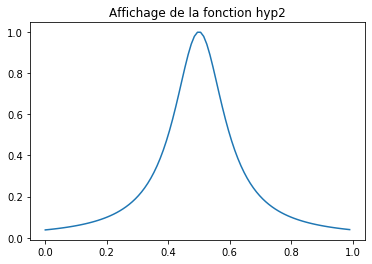

In [157]:
x = np.linspace(0,0.99,99)
h = 1
plt.title("Affichage de la fonction hyp2")
plt.plot(x , hyp2(x,h))

#### Focntions particulières

In [159]:
def absolu(x,h) : 
    x= x*h
    return np.abs(x-0.5*h)

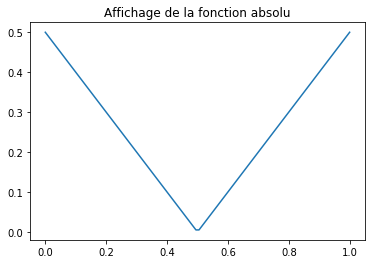

In [160]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction absolu")
plt.plot(x , absolu(x,h))

In [161]:
def creneau(x,h) : 
    x = x*h    
    return 0*(x<0.2*h) + 1*(x>=0.2*h)*(x<=0.6*h)+0*(x>0.6*h)

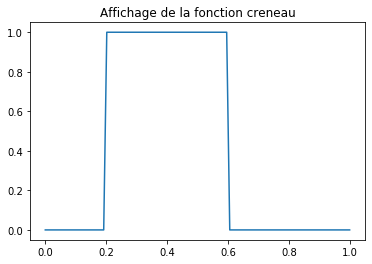

In [162]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction creneau")
plt.plot(x , creneau(x,h))

In [234]:
def sin_off(x,h) : 
    x = x*h 
    return np.sin(x) + 1.1

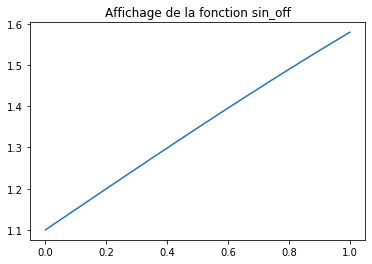

In [235]:
x = np.linspace(0,1,100)
h = 0.5
plt.title("Affichage de la fonction sin_off")
plt.plot(x , sin_off(x,h))

In [236]:
def sin_ax_b(x,h) : 
    x = x*h
    return np.sin(x) + 0.1*x + 2

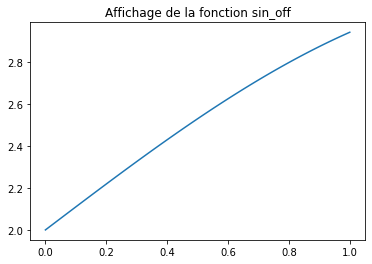

In [237]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction sin_off")
plt.plot(x , sin_ax_b(x,h))

In [165]:
def gaussienne(x,h) : 
    x = x*h
    return (1/(sqrt(2*pi)*0.1)) * np.exp(-(x-0.25)**2/(2*0.1**2))

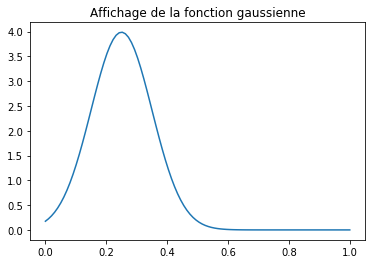

In [166]:
x = np.linspace(0,1,100)
h = 1
plt.title("Affichage de la fonction gaussienne")
plt.plot(x , gaussienne(x,h))

## Etude de l'interpolation sur de simples polynomes ou hyperboles

##### Etude de la fonction f(x) = x**2 + 1

Nombre d'itérations finales :  1


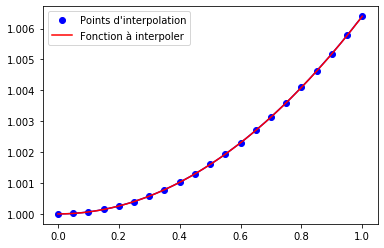

La convergence de Newton-Raphson est rapide.
 
Calcul de l'erreur de convergence globale : 
L'erreur est =  1.5679450559857866e-06


In [283]:
p = 20
h = 0.08
poln, xn, error, pol, x = interpol(p,h, pol1)
polynom_display(xn,poln,x ,pol,h,pol1)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol1,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = (10^5)*(x^10)*(1-x)^7 + 0.01

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  2.5633916303614585e-05


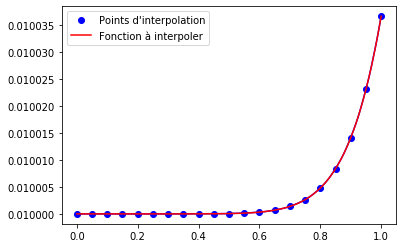

La convergence de Newton-Raphson est rapide.
 
Calcul de l'erreur de convergence globale : 
L'erreur est =  1.1593047015770461e-08


In [182]:
p = 20
h = 1/8
poln, xn, error, pol, x = interpol(p,h, pol2)
polynom_display(xn,poln , x, pol,h,pol2)


error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol2,h)
print("L'erreur est = ", err)

**Diminution de la valeur de h (essayer de sampler plus)**

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  6.149454137285153e-13


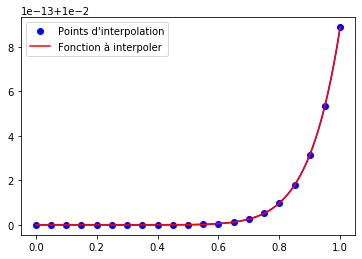

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  8.239936510889835e-18


In [183]:
p = 20
h = 0.02
poln, xn, error, pol, x = interpol(p,h, pol2)
polynom_display(xn,poln , x, pol,h,pol2)

print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,pol2,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 10*(x-1/2)**4 +3

Nombre d'itérations finales :  4
Erreur Newton-Raphson :  0.0008523651426914897


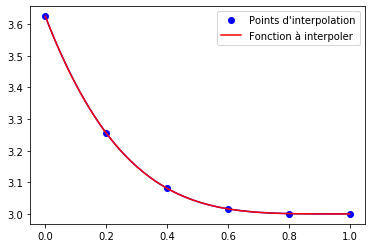

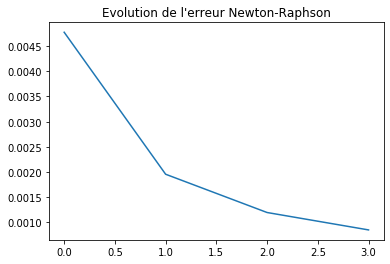

 
Calcul de l'erreur de convergence : 
L'erreur est =  4.184178357480306e-05


In [187]:
p = 5
h = 1/2
poln, xn, error, pol, x = interpol(p,h, pol3)
polynom_display(xn,poln,x, pol,h,pol3)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,pol3,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 10^5 * (x^10)* (1-x)^7 + 0.01

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  4.294458746962172e-06


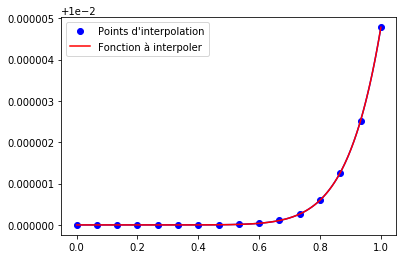

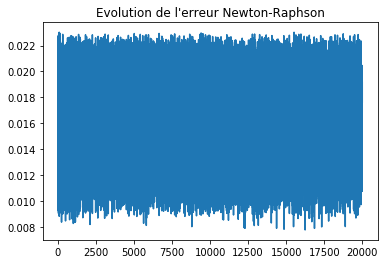

 
Calcul de l'erreur de convergence : 
L'erreur est =  7.015677789869632e-11


In [211]:
p = 15
h = 0.1
poln ,xn, ERR, pol, x = interpol(p,h,pol4, eps=1e-3)
polynom_display(xn,poln, x, pol, h, pol4)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence de Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,pol4,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 1/(1-x)

Nombre d'itérations finales :  3
Erreur Newton-Raphson :  0.0007752174976039524


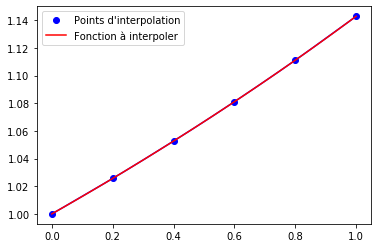

La convergence Newton-Raphson est rapide.
 
Calcul de l'erreur de convergence : 
L'erreur est =  1.1121292534910232e-05


In [188]:
p = 5
h = 1/8
poln, xn, error, pol, x = interpol(p,h, hyp1)
polynom_display(xn,poln,x ,pol,h,hyp1)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,hyp1,h)
print("L'erreur est = ", err)

##### Etude de la fonction f(x) = 1/(1+25*(2*x-1)**2)

Nombre d'itérations finales :  9
Erreur Newton-Raphson :  0.0007389519792905064


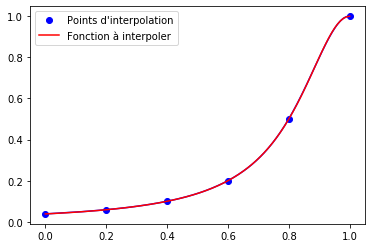

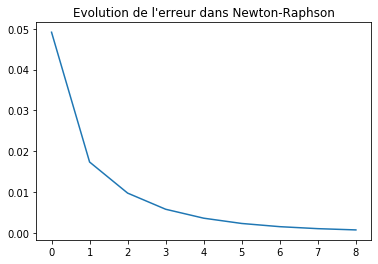

 
Calcul de l'erreur de convergence : 
L'erreur est =  0.00022969536906455865


In [189]:
p = 5
h = 1/2
poln, xn, error, pol, x = interpol(p,h, hyp2)
polynom_display(xn,poln, x, pol,h,hyp2)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")

    plt.show()
else :
    print("La convergence newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence : ")
err = erreur(xn,poln,hyp2,h)
print("L'erreur est = ", err)

## Etude de l'interpolation sur des fonctions particulières

##### Etude de la fonction valeur absolu 

Nombre d'itérations finales :  20000
Erreur Newton-Raphson :  0.013691755414478793


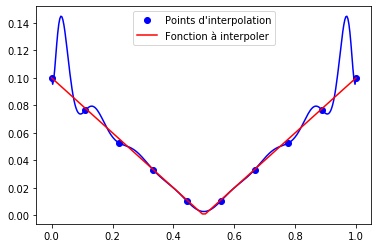

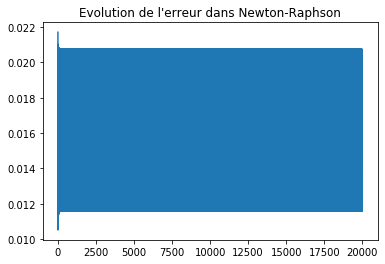

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.0011639495263207757


In [190]:
p = 9
h = 0.20
poln, xn, error, pol, x = interpol(p,h, absolu)
polynom_display(xn,poln,x ,pol,h,absolu)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,absolu,h)
print("L'erreur est = ", err)

**En essayant de diminuer h**

Nombre d'itérations finales :  20000
Erreur Newton-Raphson :  0.017646220054699936


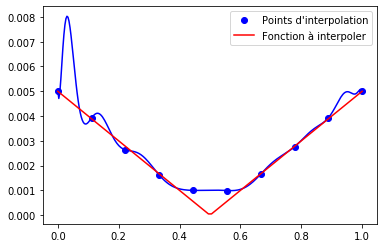

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.00013105396841706085


In [192]:
p = 9
h = 0.01
poln, xn, error, pol, x = interpol(p,h, absolu)
polynom_display(xn,poln,x ,pol,h,absolu)

print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,absolu,h)
print("L'erreur est = ", err)

##### Etude de la fonction créneau 

Nombre d'itérations finales :  9
Erreur Newton-Raphson :  0.0009302358004402513


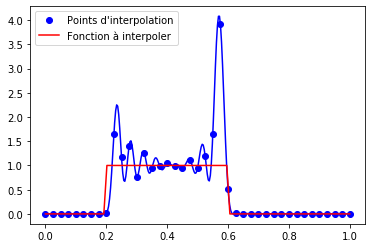

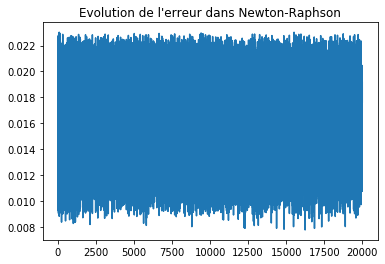

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.18427844668889787


In [199]:
p = 40
h = 0.01
poln, xn, err, pol, x = interpol(p ,h, creneau, 1e-3)
polynom_display(xn, poln,x, pol, h, creneau)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,creneau,h)
print("L'erreur est = ", err)

##### Etude de la fonction sinx + offset

Nombre d'itérations finales :  2
Erreur Newton-Raphson :  0.009927850717270021


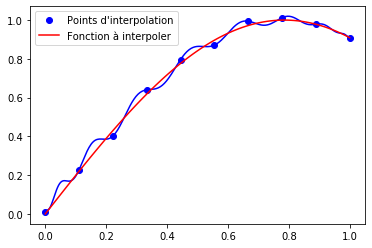

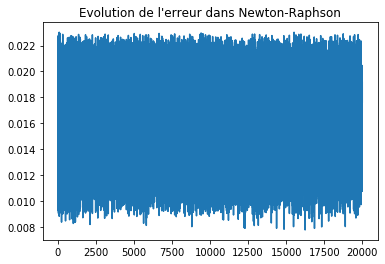

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.015873434551699716


In [205]:
p = 9
h = 0.1
poln, xn, err, pol,x = interpol(p ,h, sin_off, eps=1e-2)
polynom_display(xn, poln, x, pol, h, sin_off)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,sin_off,h)
print("L'erreur est = ", err)

##### Etude de la gaussienne

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.0014488366050518684


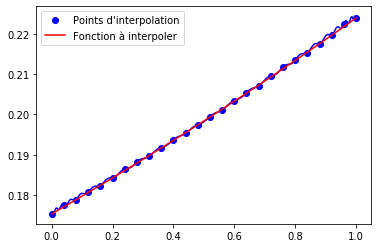

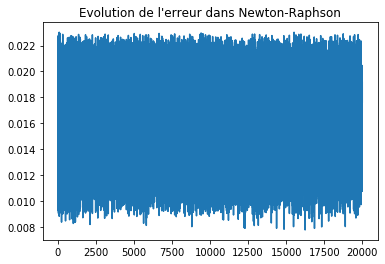

 
Calcul de l'erreur de convergence globale : 
L'erreur est =  0.0001874729153381255


In [206]:
p = 25
h = 0.01
poln, xn, err, pol,x = interpol(p ,h, gaussienne, eps=1e-2)
polynom_display(xn, poln, x, pol, h, gaussienne)

error = np.asarray(error)
if len(error) > 3 :
    plt.figure()
    plt.plot(error)
    plt.title("Evolution de l'erreur dans Newton-Raphson")
    plt.show()
else :
    print("La convergence Newton-Raphson est rapide.")
print(" ")

print("Calcul de l'erreur de convergence globale : ")
err = erreur(xn,poln,gaussienne,h)
print("L'erreur est = ", err)

## Variation de l'erreur en fonction de h, epsilon et p

##### Etude de l'erreur en fonction de epsilon

epsilon =  0.1
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  1.5067318694602236e-16


<Figure size 432x288 with 0 Axes>

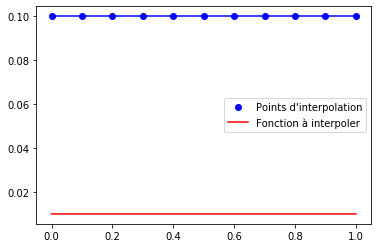

epsilon =  0.01
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  5.982979018830303e-06


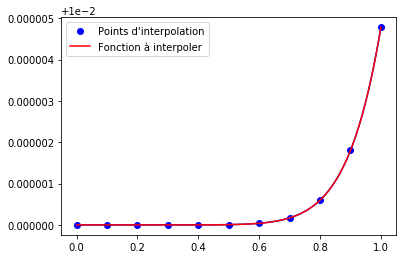

epsilon =  0.001
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  5.982979018830303e-06


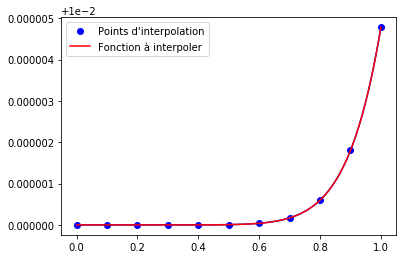

epsilon =  0.0001
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  5.982979018830303e-06


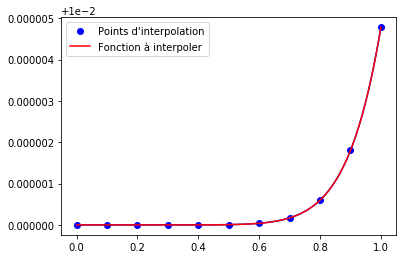

epsilon =  1e-05
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  5.982979018830303e-06


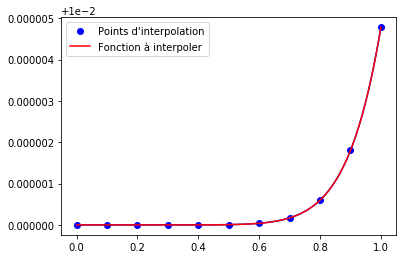

In [209]:
EPS = [0.1,0.01,0.001,0.0001,0.00001]
p = 10
h = 0.1
ERR_int = []

plt.figure()
for j in EPS :
    print("epsilon = ", j)
    poln, xn,err, pol, x = interpol(p ,h, pol4, j)
    polynom_display(xn, poln, x, pol, h, pol4)
    ERR_int += [erreur(xn, poln, pol4, h)]
plt.show()

Ordre =  2.245250926856489


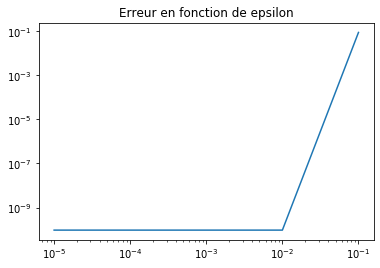

In [210]:
ERR_int = np.asarray(ERR_int)
EPS = np.asarray(EPS)
print("Ordre = ", find_order(EPS,ERR_int))


plt.figure()
plt.loglog(EPS, ERR_int)
plt.title("Erreur en fonction de epsilon")
plt.show()

Quand epsilon est trop haut, l'interpolation de la fonction est mauvaise car le polynome initial est déjà bon.
Quand espilon est trop petit, l'interpolation ne peut plus être prise en charge par le porgramme. 

##### Etude de l'erreur en fonction de H

h =  0.01
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  7.762652839474169e-16


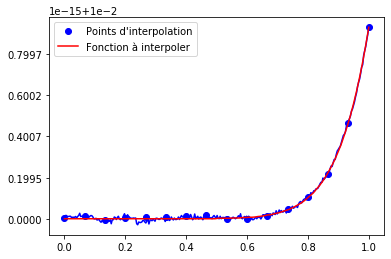

h =  0.03
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  4.236226980909833e-11


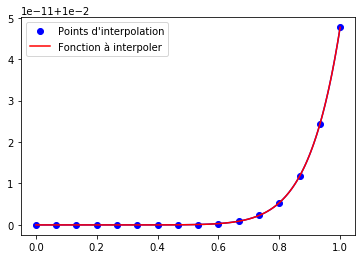

h =  0.06
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  3.497850755277576e-08


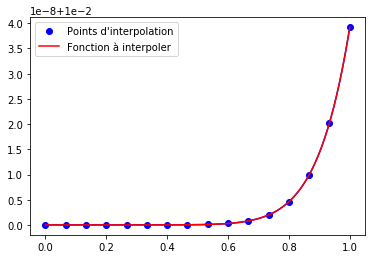

h =  0.1
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  4.294458746962172e-06


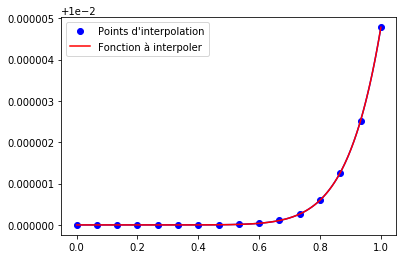

h =  0.13
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  4.680626423861131e-05


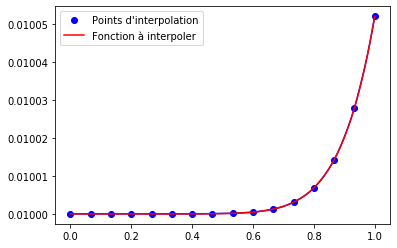

h =  0.16
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.0002884049664346626


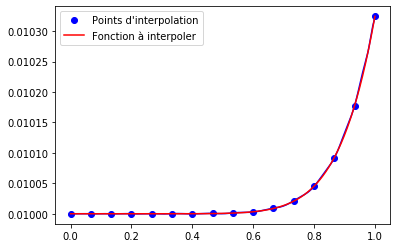

In [212]:
H = [0.01,0.03,0.06,0.1,0.13,0.16]
ERR_int = []

for i in H :
    print("h = ", i)
    poln, xn, err, pol, x = interpol(p ,i, pol4)
    polynom_display(xn, poln,x,pol, i, pol4)
    ERR_int += [erreur(xn, poln, pol4, h)]

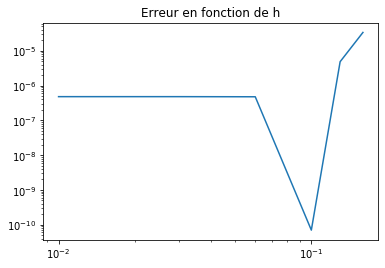

In [213]:
ERR_int = np.asarray(ERR_int)
H = np.asarray(H)
plt.figure()
plt.loglog(H, ERR_int)
plt.title("Erreur en fonction de h")
plt.show()

Quand h devient trop grand, il n'est plus possible de gérer l'interpolation 

##### Etude de l'erreur en fonction de P

P =  5
Nombre d'itérations finales :  13
Erreur Newton-Raphson :  8.444911985477121e-05


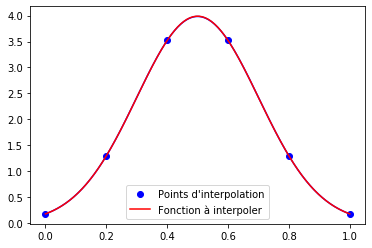

P =  15
Nombre d'itérations finales :  16
Erreur Newton-Raphson :  9.261522877020103e-05


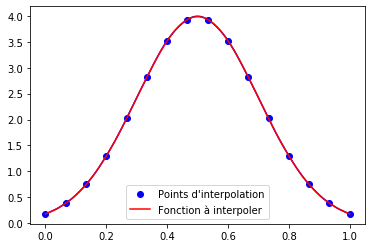

P =  25
Nombre d'itérations finales :  20000
Erreur Newton-Raphson :  0.00046684670417135126


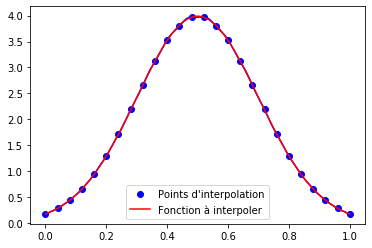

P =  35
Nombre d'itérations finales :  20000
Erreur Newton-Raphson :  0.0008816624843813837


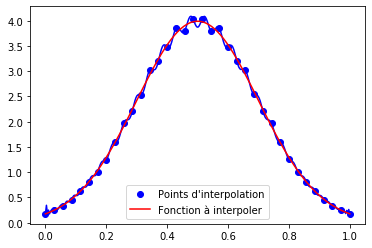

In [215]:
ERR_int = []
P = [5,15,25,35]
for p in P : 
    h = 1/2
    print("P = ", p)
    poln, xn, err, pol, x = interpol(p ,h, gaussienne,1e-4)
    ERR_int += [erreur(xn, poln, pol4, h)]
    polynom_display(xn, poln, x, pol, h, gaussienne)

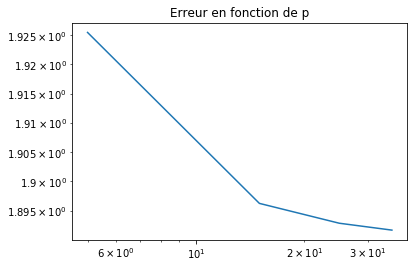

In [216]:
ERR_int = np.asarray(ERR_int)
P = np.asarray(P)
plt.figure()
plt.loglog(P, ERR_int)
plt.title("Erreur en fonction de p")
plt.show()

## Etude de l'ordre d'interpolation entre sinx et sinx + ax +b 

*L'idée est ici de montrer que sin(x) et sin(x) +ax+ b ont le même ordre de convergence même si les points d'interpolation obtenu ne sont pas les mêmes*

h =  0.1
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.0008732993295250774


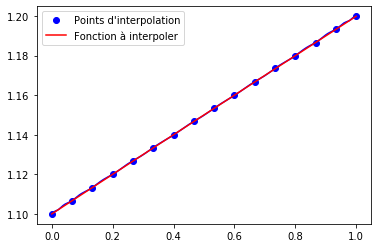

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.0005417833737356124


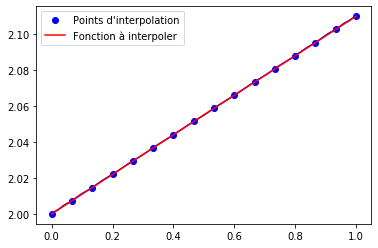

h =  0.05
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.000451245358615871


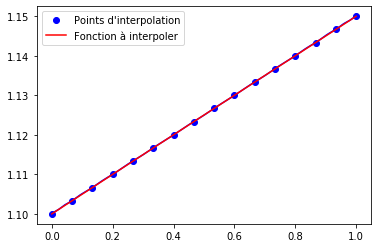

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  0.0002765562605805102


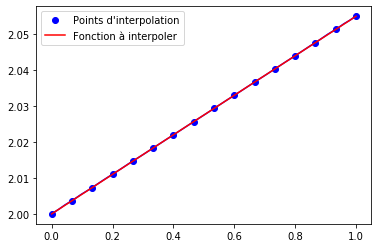

h =  0.01
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  9.269119604245272e-05


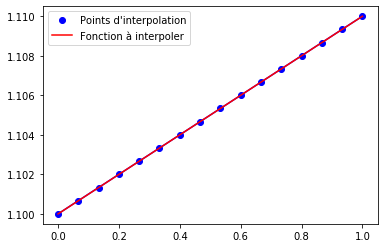

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  5.622686720088123e-05


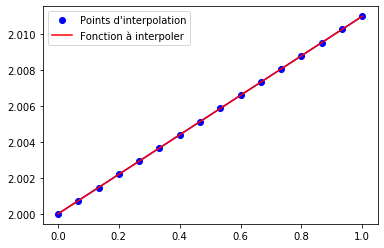

h =  0.005
Nombre d'itérations finales :  1
Erreur Newton-Raphson :  4.650173274652768e-05


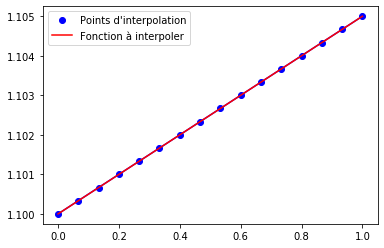

Nombre d'itérations finales :  1
Erreur Newton-Raphson :  2.8170933755920607e-05


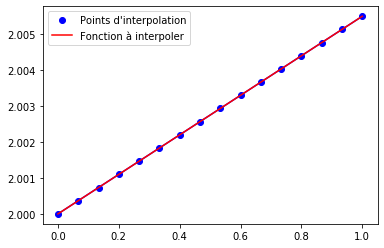

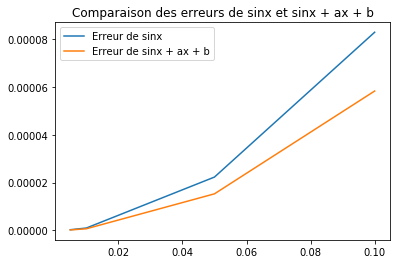

Ordre de la première méthode =  1.9535416214807553
Ordre de la seconde méthode =  1.9709689805168704


In [246]:
H = [0.1,0.05,0.01,0.005]
ERR1 = []
ERR2 = []

for h in H : 
    print("h = ", h)
    poln, xn, err, pol, x = interpol(p ,h, sin_off)
    polynom_display(xn, poln,x,pol, h, sin_off)
    ERR1 += [erreur(xn, poln, sin_off, h)]
    
    poln1, xn1, err1, pol1, x1 = interpol(p ,h, sin_ax_b)
    polynom_display(xn1, poln1,x1,pol1, h, sin_ax_b)
    ERR2 += [erreur(xn1, poln1, sin_ax_b, h)]

plt.figure()
plt.plot(H,ERR1, label = "Erreur de sinx")
plt.plot(H,ERR2, label = "Erreur de sinx + ax + b")
plt.title("Comparaison des erreurs de sinx et sinx + ax + b")
plt.legend()
plt.show()

print("Ordre de la première méthode = ", find_order(H, ERR1))
print("Ordre de la seconde méthode = ", find_order(H, ERR2))

## Etude des points initiaux différents de Chebytchev

##### Tests avec des points espacés uniformément

In [325]:
def start_point_uni(p):
    I = np.linspace(0.01,1,2*(p+1))
    I = I.reshape((np.shape(I)[0], 1))
    print(np.shape(I))
    return I

In [326]:
def Newton_Raphson_pts_uni(p,h ,function,eps=1e-3)  :
    X0 = start_point_uni(p)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat(X,h,p,function,eps)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR

In [327]:
def interpol_pts_uni(p,h,function, eps=1e-3) :
    X, ERR = Newton_Raphson_pts_uni(p, h, function, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x

(42, 1)
Nombre d'itérations finales :  1


D:\EMMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\EMMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


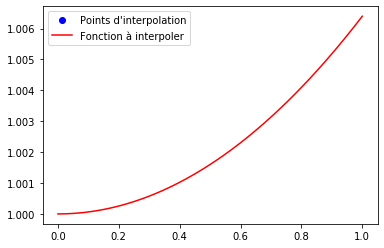

Valeurs de poln pour des points initiaux qui ne sont pas de la forme de Chebytchev :  [[nan]
 [nan]
 [nan]
 [nan]
 [nan]]


In [337]:
p = 20
h = 0.08
poln, xn, error, pol, x = interpol_pts_uni(p,h, pol1)
polynom_display(xn,poln,x ,pol,h,pol1)
print("Valeurs de poln pour des points initiaux qui ne sont pas de la forme de Chebytchev : ", poln[:5])

*On peut donc constater que lorsque les points initiaux ne sont pas d'une certaine forme, il est beaucoup plus compliqué de trouver des points d'interpolation. En effet, ces points créent des "impossibilitées de calculs*

##### Tests avec des points en Gaussienne

In [383]:
def start_point_gauss(p):
    x = np.linspace(0,1,2*(p+1))
    I = np.exp((-(x - 0.5)**2)/(0.5))-0.2
    I = I.reshape((np.shape(I)[0], 1))
    print(I)
    return I

In [384]:
def Newton_Raphson_pts_gauss(p,h ,function,eps=1e-3)  :
    X0 = start_point_gauss(p)
    X = np.concatenate((X0[:p], X0[p+2:]))
    X_past = X + 2*eps
    err = 2*eps
    ERR = []
    i = 0
    while npl.norm(X-X_past)/npl.norm(X) > eps and i<20000:
        X_past = X
        X = G_hat(X,h,p,function,eps)
        i+=1
        ERR += [npl.norm(X - X_past)/npl.norm(X)]
    print("Nombre d'itérations finales : ",i)
    #print("Erreur Newton-Raphson : ", ERR[-1])
    return X, ERR

In [385]:
def interpol_pts_gauss(p,h,function, eps=1e-3) :
    X, ERR = Newton_Raphson_pts_gauss(p, h, function, eps)
    X = np.concatenate((X[:p], [[1]], [[0]], X[p:]))
    
    xn = np.zeros((p+1,1))
    xn[:,0] = np.linspace(0,1,p+1)
    
    ar = X[:p+1]
    br = X[p+1:]
    
    A = a(xn, ar, h, p, function,eps )
    B = b(xn, br, h, p, function,eps )
    poln = polynom(xn, A, B)

    x = np.linspace(0,1,300)
    A_pol = a(x, ar, h, p ,function, eps)
    B_pol = b(x, br, h, p ,function, eps)
    pol = polynom(x, A_pol, B_pol)

    
    return poln, xn, ERR, pol, x

In [386]:
p = 20
h = 0.08
poln, xn, error, pol, x = interpol_pts_gauss(p,h, gaussienne)
polynom_display(xn,poln,x ,pol,h,gaussienne)
print("Valeurs de poln pour des points initiaux qui ne sont pas de la forme de Chebytchev : ", poln[:5])

[[0.40653066]
 [0.43609378]
 [0.46551234]
 [0.4946366 ]
 [0.5233122 ]
 [0.5513815 ]
 [0.57868497]
 [0.60506262]
 [0.63035559]
 [0.65440768]
 [0.67706697]
 [0.69818739]
 [0.71763026]
 [0.73526586]
 [0.75097482]
 [0.76464948]
 [0.77619511]
 [0.78553104]
 [0.79259153]
 [0.7973266 ]
 [0.7997026 ]
 [0.7997026 ]
 [0.7973266 ]
 [0.79259153]
 [0.78553104]
 [0.77619511]
 [0.76464948]
 [0.75097482]
 [0.73526586]
 [0.71763026]
 [0.69818739]
 [0.67706697]
 [0.65440768]
 [0.63035559]
 [0.60506262]
 [0.57868497]
 [0.5513815 ]
 [0.5233122 ]
 [0.4946366 ]
 [0.46551234]
 [0.43609378]
 [0.40653066]]
[[0.        ]
 [0.7973266 ]
 [0.79259153]
 [0.78553104]
 [0.77619511]
 [0.76464948]
 [0.75097482]
 [0.73526586]
 [0.71763026]
 [0.69818739]
 [0.67706697]
 [0.65440768]
 [0.63035559]
 [0.60506262]
 [0.57868497]
 [0.5513815 ]
 [0.5233122 ]
 [0.4946366 ]
 [0.46551234]
 [0.43609378]
 [0.40653066]]
[[0.        ]
 [0.79523721]
 [0.78641223]
 [0.77552066]
 [0.76276771]
 [0.74835212]
 [0.73245847]
 [0.71525114]
 [0.

D:\EMMA\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


ValueError: math domain error

## Etude de l'erreur des différentes façons de mesurer l'erreur d'interpolation

Nombre d'itérations finales :  5
Erreur Newton-Raphson :  0.0009432512301467774


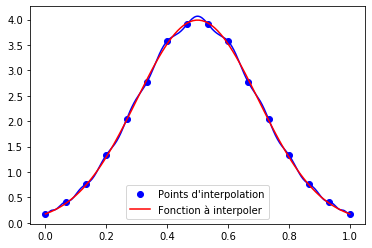

Erreur en npl.norm =  0.13732186393165943
Erreur en quadrature =  0.03076932012878439


In [223]:
p = 15
h = 0.5

poln, xn, err, pol, x = interpol(p ,h, gaussienne,1e-3)
polynom_display(xn, poln, x, pol, h, gaussienne)

print("Erreur en npl.norm = ", npl.norm(poln - gaussienne(xn, h)))
print("Erreur en quadrature = ", erreur(xn, poln, gaussienne,h))

## Schéma advection-diffusion

In [387]:
def u0(x,h) :
    x = x*h
    return np.cos(pi * x)**2 +1 

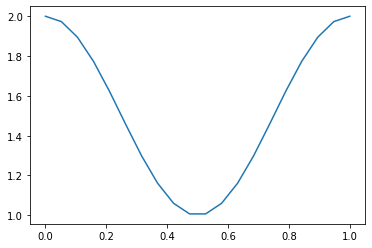

In [388]:
x = np.linspace(0,1,20)
h = 1 
plt.figure()
plt.plot(x,u0(x,h))
plt.show()

In [399]:
def schema_diffusion (u0, dt, dx, T) : 
    u = np.copy(u0)
    u_i1 = np.zeros_like(u)
    u_i_1 = np.zeros_like(u)
    a = 1
    
    t = 0
    while t<T : 
        u_i1[:-1] = u[1:]
        u_i1[-1] = u[0]
        u_i_1[1:] = u[:-1]
        u_i_1[0] = u[-1]
        
        u += -a*(dt/dx)*(u_i1 - u_i_1)
        t += dt
    return u 

Nombre d'itérations finales :  1


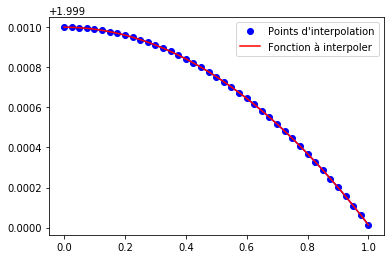

In [400]:
p = 40
h = 0.01
poln, xn, err, pol, x = interpol(p ,h, u0, 1e-3)
polynom_display(xn, poln, x, pol, h, u0)

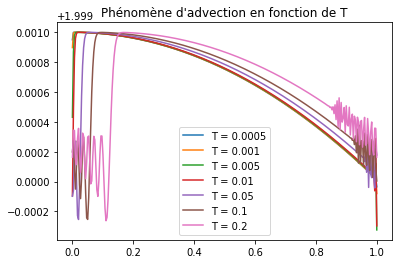

In [396]:
dt = 0.0001
T = [0.0005,0.001,0.005,0.01,0.05,0.1,0.2]
plt.figure()
for t in T : 
    u_new_pol = schema_diffusion(pol, dt,h,t)
    plt.plot(x, u_new_pol, label = "T = "+ str(t))
plt.title("Phénomène d'advection en fonction de T")
plt.legend()
plt.show()
#u_new = schema_diffusion(poln, dt, h , t)
#u_new_pol = schema_diffusion(pol, dt,h,T)
#plt.plot(xn,u_new, 'or')